In [25]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


import os
import numpy as np # linear algebra
from PIL import Image

import random

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms

import cv2
# In[7]:


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# In[8]:


class CenterCrop(object):
    def __init__(self,arg):
        self.transform = transforms.CenterCrop(arg)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),self.transform(label)

class Resize(object):
    def __init__(self,arg):
        self.transform_img = transforms.Resize(arg,Image.BILINEAR)
        self.transform_label = transforms.Resize(arg,Image.NEAREST)

    def __call__(self, sample):
        img, label = sample
        return self.transform_img(img),self.transform_label(label)

class Normalize(object):
    def __init__(self,mean,std):
        self.transform = transforms.Normalize(mean, std)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),label

class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        img, label = sample
        label = np.array(label)/255
        img = np.array(img)
        img = (img-img.min())/(img.max()-img.min())
        return torch.from_numpy(img.transpose((2, 0, 1))).float(),torch.from_numpy(label.copy()).long()

class RandomRescale(object):
    def __init__(self,min_ratio=0.5,max_ratio=1.0):
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio
    def __call__(self, sample):
        img, label = sample
        width, height = img.size
        ratio = random.uniform(self.min_ratio,self.max_ratio)
        new_width, new_height = int(ratio*width), int(ratio*height)
        return img.resize((new_width,new_height)), label.resize((new_width,new_height))

class RandomFlip(object):
    def __init__(self,p=0.5):
        self.p = p

    def __call__(self, sample):
        img, label = sample
        if random.uniform(0,1)>self.p:
            return transforms.functional.hflip(img),transforms.functional.hflip(label)
        else:
            return img, label

class RandomColor(object):
    def __init__(self,brightness=0.3,contrast=0.3,saturation=0,hue=0):
        self.transform = transforms.ColorJitter(brightness,contrast,saturation,hue)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),label

class RandomRotation(object):
    def __init__(self, degree=[-3,3]):
        self.degree = degree

    def __call__(self, sample):
        img, label = sample

        angle = transforms.RandomRotation.get_params(self.degree)

        img = transforms.functional.rotate(img, angle,resample = Image.BILINEAR)
        label = transforms.functional.rotate(label, angle)
        return img, label

class RandomCrop(object):
    def __init__(self,output_size):
        self.output_size = output_size
    def __call__(self, sample):
        img, label = sample

        i, j, h, w = transforms.RandomCrop.get_params(
            img, output_size=self.output_size)

        img = transforms.functional.crop(img, i, j, h, w)
        label = transforms.functional.crop(label, i, j, h, w)
        return img,label

    
class CovidCTDataset(Dataset):
    """Covid XRay dataset."""

    def __init__(self, txt, transforms):
        self.IMAGE_LIB = '../Segmen/data/2d_images/'
        self.MASK_LIB = '../Segmen/data/2d_masks/'
    
        self.images = np.loadtxt(txt,dtype=str)
        
        self.transform = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_name = self.images[idx]
        img = cv2.imread(self.IMAGE_LIB + image_name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = Image.fromarray(np.uint8(img*255)).convert('RGB')
        label = Image.open(self.MASK_LIB + image_name)
        if self.transform:
            img,label = self.transform((img,label))
        sample = {'img': img,
                  'label': label}
        return sample


# In[9]:


transform = transforms.Compose([
        RandomRescale(0.8,1.2),
        RandomCrop((224,224)),
        RandomColor(),
        RandomFlip(),
        RandomRotation(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
test_transform = transforms.Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
train_dst = CovidCTDataset(txt='../Segmen/train.txt',
                           transforms=transform)
valid_dst = CovidCTDataset(txt='../Segmen/test.txt',
                           transforms=test_transform)
batch_size = 8
print("Train set {}\nValidation set {}\n".format(len(train_dst),len(valid_dst)))

train_loader = DataLoader(train_dst,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_dst,batch_size=batch_size,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model = nn.DataParallel(model).to(device)
print("=> loading checkpoint '{}'".format('best.pth.tar'))
checkpoint = torch.load('best.pth.tar', map_location="cpu")

state_dict = checkpoint['state_dict']
                
msg = model.load_state_dict(state_dict)

Train set 200
Validation set 67

=> loading checkpoint 'best.pth.tar'


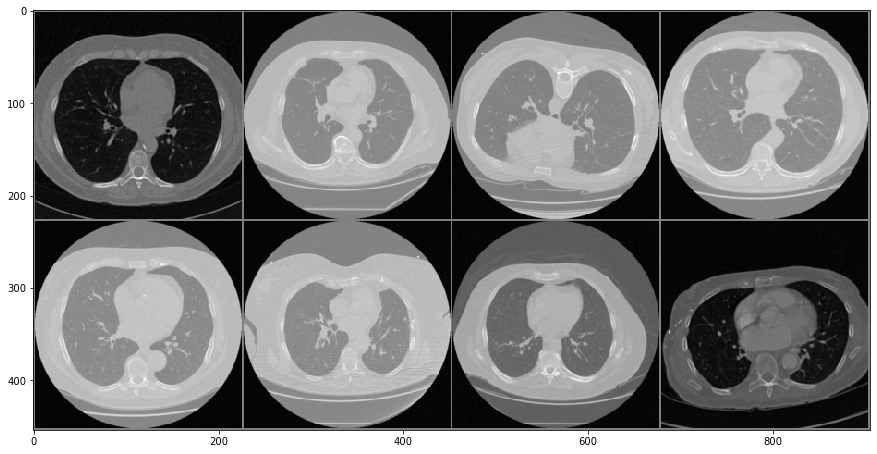

torch.Size([8, 3, 224, 224])
(3, 454, 906)


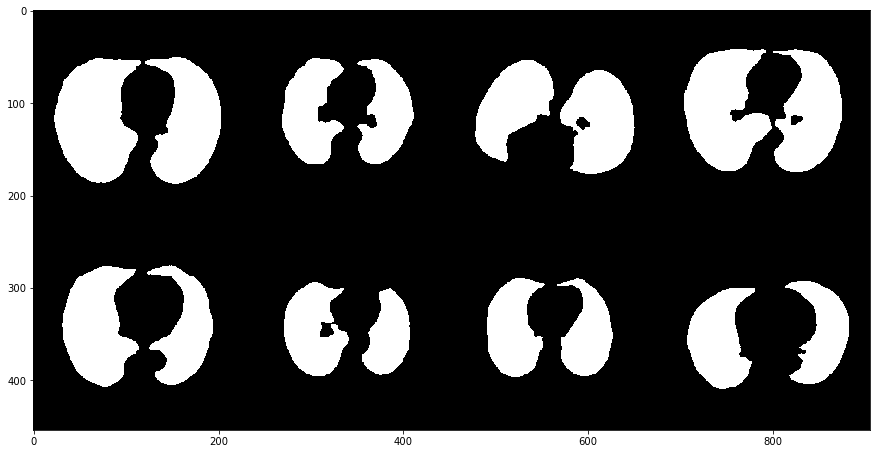

torch.Size([8, 3, 224, 224])
(3, 454, 906)


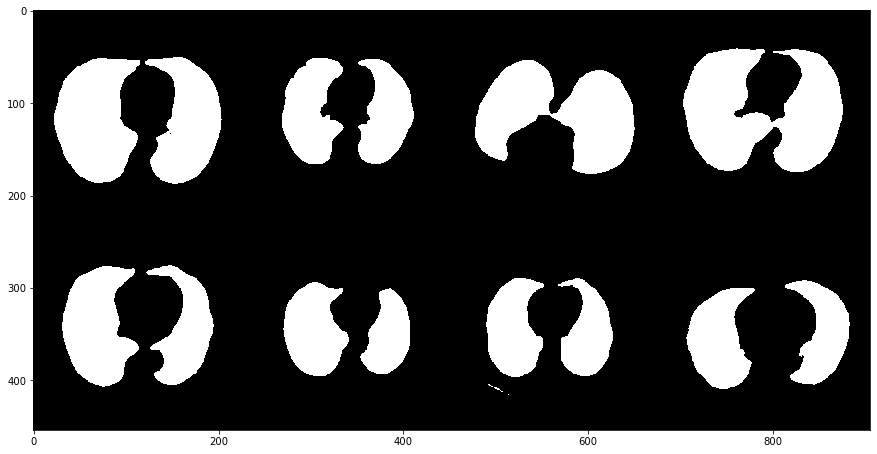

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline 
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(valid_loader)
batch = dataiter.next()
images, labels = batch['img'], batch['label']
# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
labels_image = torch.cat([labels.unsqueeze(1),labels.unsqueeze(1),labels.unsqueeze(1)],dim=1)
print(labels_image.shape)
imshow_pred(torchvision.utils.make_grid(labels_image,nrow=4))
# print labels
output = model(images.to(device))
_, preds = torch.max(output, 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))